## Reading and visualizing the data

In the search for a solution ot keep all 50 million images in memory i evaluated:
- generating and compressing grasycale images 
- compressing the drawing



Both methods works: 
- Webp compression for grayscale images is very efficient with a fast decompression. The compression takes about 5h 30 min 
- Brotli compression of strokes in text format is as efficient as bz2 decompresses. Both compress much better than zlib. Brotli and zlib's decompression is 3 times fast compared to bz2. The compression takes about 10h 30 min (very slow compared to bz2 and zlib). 
- i have a macbook pro mid 2016

Decompression of 50 million images can be generated form the compressed state to images in 13 and 26 min from the compressed drawing and compressed images respectively


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import json
import math
import cv2
import brotli
from PIL import Image, ImageDraw
from io import BytesIO,SEEK_SET

import gc

In [3]:
input_data       = Path("/Users/kasparlund/DropBox")
data             = Path("../data/google_quick_draw")

stroke_dir       = input_data/"train_simplified"
one_stroke_file  = stroke_dir/"ambulance.csv"

data_prepared    = data/"prepared"

#astrokes_file = data_prepared/"train_simplified.csv"
attribute_file  = data_prepared/"train_simplified_attributes.csv"
vocab_file       = data_prepared/"vocab.json"

In [4]:
size, line_width  = 28, 1
valid_ratio = 0.1
linetype    = cv2.LINE_8 #cv2.LINE_AA
compressed_drawings = True

images_file      = data_prepared/f"imgs_webp_{size}x{size}_lw{line_width}.pkl"
drawings_file    = data_prepared/f"c_drawings.pkl"
train_valid_name = "c_drawing_train_valid" if compressed_drawings else \
                    f"c_image_train_valid_{size}x{size}_lw{line_width}.gzip"
train_valid_file = data_prepared/f"{train_valid_name}.gzip"

In [5]:
print(data.exists()), print(one_stroke_file.exists())
images_file,train_valid_file

True
True


(PosixPath('../data/google_quick_draw/prepared/imgs_webp_28x28_lw1.pkl'),
 PosixPath('../data/google_quick_draw/prepared/c_drawing_train_valid.gzip'))

## code

In [6]:
#convert strokes to an image
min_color        = 10 #so that we can see the line
max_color        = 255-min_color #symmetri
max_stroke_coord = 255

def strokes2image(str_strokes:str, size:int=256, lw:int=6, linetype=cv2.LINE_8):
    stroke_scale= size / (max_stroke_coord+1)
    #scale coordinates to image size
    strokes     = [ [np.transpose((0.5+stroke_scale*np.asarray(s, dtype=np.float))).astype(dtype=np.int32)] 
                   for s in json.loads(str_strokes)]
    
    #scale color to the stroke index (alias for time)            
    scale_color = max_color//len(strokes)
    colors      = [ min_color + scale_color*i for i in range(len(strokes)) ]
    
    img         = np.zeros((size, size), np.uint8)
    for color, s in zip(colors,strokes):
        cv2.polylines(img, s, False, color, lw, linetype)
        #cv2.polylines(img, s, isClosed=False, color=color, thickness=lw)
        
    return img

def convert_strokes2image(drawings, size, line_width, linetype, compressed_drawings):
    "convert strokes to images"
    ims = []
    for drawing in drawings : 
        if compressed_drawings:
            im = strokes2image( brotli.decompress(drawing).decode("utf-8"), size=size, lw=line_width, linetype=linetype)
        else: 
            im = strokes2image( drawing, size=size, lw=line_width, linetype=linetype)
        ims.append( im )
    return ims


In [7]:
#compressing and decompressing images
def convert_strokes2webp(drawings, size, line_width):
    "convert strokes to images"
    ims = []
    for drawing in drawings :            
        im = strokes2image( drawing, size=size, lw=line_width)
        with BytesIO() as byteIO:
            im = Image.fromarray(im).save(byteIO, format="webp", lossless=True ) #, quality=100)
            ims.append( byteIO.getvalue() )
    return ims

def decode_images(imgs:list):
    ims_de = []    
    for im in imgs :
        with BytesIO( im ) as byteIO:
            ims_de.append( np.asarray(Image.open(byteIO).convert("L")) )            
    return ims_de

def loadall(pickle_file):
    with open(pickle_file, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

def readall(pickle_file ):
    "return a list of images compressed and save by merge_stroke_files"
    imgs = []
    for imgs_section in loadall(pickle_file):
        imgs.extend( imgs_section )
        gc.collect()    
    return imgs


In [8]:
#graphics
def plot_images( ims, cmap=cm.Greys, max_rows_cols=10 ):
    n        = max(2,min(max_rows_cols, int(math.sqrt(len(ims))) ))
    fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
    n_figs   = min(len(ims),n**2)
    for i in range(n_figs):
        ax = axs[i // n, i % n]
        ax.imshow( ims[i], cmap=cm.Greys)
        ax.axis('off')
    plt.tight_layout()

## analyses one data tabel

## Prepare training files

replace space in words and save an attribute file and a file with compressed images/drawings
read the compressed imageds/drawings and create a dataset for training and validation with the numericalize labels, tagging of training and validation data, the compressed drawing/images

## code

In [9]:
#convert strokes to an image
min_color        = 10 #so that we can see the line
max_color        = 255-min_color #symmetri
max_stroke_coord = 255

def strokes2image(str_strokes:str, size:int=256, lw:int=6, linetype=cv2.LINE_8):
    stroke_scale= size / (max_stroke_coord+1)
    #scale coordinates to image size
    strokes     = [ [np.transpose((0.5+stroke_scale*np.asarray(s, dtype=np.float))).astype(dtype=np.int32)] 
                   for s in json.loads(str_strokes)]
    
    #scale color to the stroke index (alias for time)            
    scale_color = max_color//len(strokes)
    colors      = [ min_color + scale_color*i for i in range(len(strokes)) ]
    
    img         = np.zeros((size, size), np.uint8)
    for color, s in zip(colors,strokes):
        cv2.polylines(img, s, False, color, lw, linetype)
        #cv2.polylines(img, s, isClosed=False, color=color, thickness=lw)
        
    return img

def convert_strokes2image(drawings, size, line_width, linetype, compressed_drawings):
    "convert strokes to images"
    ims = []
    for drawing in drawings : 
        if compressed_drawings:
            im = strokes2image( brotli.decompress(drawing).decode("utf-8"), size=size, lw=line_width, linetype=linetype)
        else: 
            im = strokes2image( drawing, size=size, lw=line_width, linetype=linetype)
        ims.append( im )
    return ims


In [10]:
#compressing and decompressing images
def convert_strokes2webp(drawings, size, line_width):
    "convert strokes to images"
    ims = []
    for drawing in drawings :            
        im = strokes2image( drawing, size=size, lw=line_width)
        with BytesIO() as byteIO:
            im = Image.fromarray(im).save(byteIO, format="webp", lossless=True ) #, quality=100)
            ims.append( byteIO.getvalue() )
    return ims

def decode_images(imgs:list):
    ims_de = []    
    for im in imgs :
        with BytesIO( im ) as byteIO:
            ims_de.append( np.asarray(Image.open(byteIO).convert("L")) )            
    return ims_de

def loadall(pickle_file):
    with open(pickle_file, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

def readallImages(pickle_file ):
    "return a list of images compressed and save by merge_stroke_files"
    imgs = []
    for imgs_section in loadall(pickle_file):
        imgs.extend( imgs_section )
        gc.collect()    
    return imgs


In [11]:
# Numericalization of labels
# We try to get then same validation ratio for each label
def split_train_valid_in_place( df, ix_train_valid_col:int, valid_ratio:float):
    # increase valid_ratio is a bit high due to truncation that happens when doing randomization in groups
    valid_ratio = 1.06*valid_ratio
 
    k=0
    for n,g in df.groupby("word_code"):
        if len(g) > 1: 
            ix_valid = np.random.randint(0, len(g), size=int( len(g)*valid_ratio+.5) )
            df.iloc[g.index[ix_valid], ix_train_valid_col] = False 
    gc.collect()
    valid_ratio_measured = (1- sum(df["train_valid"]) / len(df) )
    print(f"Specificied validation ratio:{valid_ratio} measured ration:{valid_ratio_measured}" )

In [12]:
#graphics
def plot_images( ims, cmap=cm.Greys, max_rows_cols=10 ):
    n        = max(2,min(max_rows_cols, int(math.sqrt(len(ims))) ))
    fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
    n_figs   = min(len(ims),n**2)
    for i in range(n_figs):
        ax = axs[i // n, i % n]
        ax.imshow( ims[i], cmap=cm.Greys)
        ax.axis('off')
    plt.tight_layout()

In [13]:
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

import pickle
def merge_stroke_files(stroke_dir:Path, attribute_file:Path, vocab_file:Path, compressed_file:Path, compressed_drawings:bool ):
    total_rows = 0
    
    #nan_label = ""
    vocab = {}
    token = 0
    #vocab[""] = token
    
    attribute_columns = train_valid_columns = None
    with attribute_file.open("w", encoding="utf-8") as f_attributes:
        files        = list( stroke_dir.glob("*.csv") )
        write_header = True
        for f in  progress_bar(files):
            print(f"processing: {f.name}")
            df = pd.read_csv(f)
            df.drop(["timestamp"], axis=1, inplace=True)
                
            #replace space in label with _, add label to vocab and create word_code column
            if sum(pd.isna(df['word'])) > 0: print(f"nan in word field for file:{f}")
            df["word"] = df["word"].apply( lambda word: word.strip().replace(" ", "_") )
            vocab[df["word"][0]] = token
            df["word_code"]      = token
            token += 1
                
            if attribute_columns is None:
                attribute_columns   = [c for c in df.columns if c not in ["drawing"] ]
                #train_valid_columns = ["word_code","drawing"]
                    
            #include header at first write
            df.to_csv(f_attributes,  columns=attribute_columns,   header=write_header, mode='a', encoding='utf-8') 
            #df.to_csv(f_train_valid, columns=train_valid_columns, header=write_header, mode='a', encoding='utf-8') 
            write_header = False
            
            if compressed_drawings : 
                compressed = [brotli.compress(txt.encode("utf-8")) for txt in df["drawing"] ]
            else:    
                compressed = convert_strokes2webp(df["drawing"], size, line_width)
                
            #the value of images_file is set by the user accoridn to whether we compress drawings or images    
            with compressed_file.open("ba+") as fp:
                pickle.dump(compressed, fp, protocol=pickle.HIGHEST_PROTOCOL)
                
            total_rows += df.shape[0]
                                           
    with open(vocab_file, 'w') as fp:
        json.dump(vocab, fp)
                                           
    print(f"total number of drawing: {total_rows}") 
    print(f"vocab size:{len(vocab)}:\n{vocab}")
    gc.collect()

import operator
def map_word_codes_to_label( vocab, word_codes):
    categories = [k for k,v in sorted(vocab.items(), key=operator.itemgetter(1))]
    return pd.Series( pd.Categorical.from_codes(word_codes, categories=categories, ordered=True) )
#words = map_word_codes_to_label( vocab, df_train["word_code"])
#words.cat.ordered, words.cat.categories.tolist()


if not attribute_file.exists():
    #%time merge_stroke_files(stroke_dir, attribute_file, vocab_file, images_file)
    if compressed_drawings: 
        %time merge_stroke_files(stroke_dir, attribute_file, vocab_file, drawings_file, compressed_drawings=compressed_drawings)
    else:
        %time merge_stroke_files(stroke_dir, attribute_file, vocab_file, images_file,   compressed_drawings=False)        
        

In [14]:
if not train_valid_file.exists():
    %time compressed_art = readall( drawings_file if compressed_drawings else images_file )
    gc.collect()
    print(f"number of images {len(compressed_art)}")
    
    #plot random images to verify that we can decode random the compressed drawings
    comp_art = [compressed_art[i] for i in np.random.randint(0,len(compressed_art),1000)]
    %time ims = convert_strokes2image( comp_art, size, line_width, linetype, compressed_drawings) \
                if compressed_drawings else decode_images( comp_art )
    plot_images( ims, cm.Greys, max_rows_cols=8 )    

In [15]:
#create a training file with numericalized words and training vs validation samples
if not train_valid_file.exists():
    with vocab_file.open('r') as fp:
        vocab = json.load(fp)
                                 
    %time df_train = pd.read_csv(attribute_file, usecols=["word_code"], dtype={'word_code': np.uint16})
    
    if compressed_drawings:
        %time df_train["c_drawings"] = compressed_art 
    else:     
        %time df_train["c_images"]   = compressed_art 
    
    df_train["train_valid"] = True
    %time split_train_valid_in_place( df_train, df_train.columns.get_loc("train_valid"), valid_ratio )
    print(df_train["train_valid"].nbytes, df_train["word_code"].nbytes, df_train.shape )
    print(df_train["c_drawings" if compressed_drawings else "c_imgs"].nbytes )
    df_train.head() 
    
    gc.collect()
    #produce the file for training
    %time df_train.to_pickle(train_valid_file)

# in the training phase we would read data as shown below

In [16]:
df_train=None
gc.collect()
%time df_train = pd.read_pickle(train_valid_file)

CPU times: user 14.4 s, sys: 26.8 s, total: 41.2 s
Wall time: 46.5 s


CPU times: user 92 ms, sys: 7.61 ms, total: 99.6 ms
Wall time: 103 ms


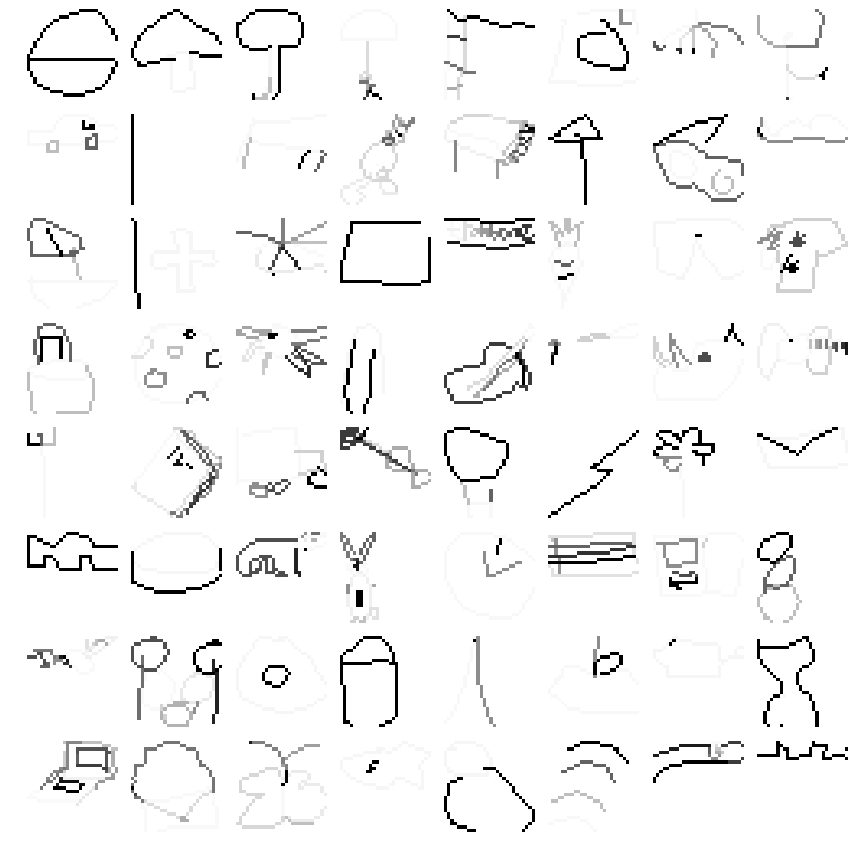

In [19]:
if compressed_drawings:
    compressed = [df_train.c_drawings.iloc[i] for i in np.random.randint(0,len(df_train),1000) ]
    %time ims = convert_strokes2image(compressed, size, line_width, linetype, compressed_drawings) 
else:    
    compressed = [df_train.c_imgs.iloc[i] for i in np.random.randint(0,len(df_train),1000) ]             
    %time ims = decode_images( compressed )
    
plot_images( ims, cm.Greys, max_rows_cols=8 )